# **Domain Proyek: Prediksi Curah Hujan dengan LSTM**

Curah hujan berperan penting dalam manajemen risiko banjir, pertanian, dan perencanaan kota. Proyek ini bertujuan memprediksi curah hujan 14 hari ke depan berdasarkan data cuaca historis Jakarta menggunakan algoritma LSTM (Long Short-Term Memory).

### Problem Statement:
- Bagaimana memprediksi apakah akan terjadi hujan atau tidak dalam 14 hari ke depan berdasarkan data historis?

### Solution Statement:
- Menggunakan LSTM karena model ini cocok untuk mempelajari pola urutan data (time series) dalam cuaca.

### Sumber Dataset:
- Dataset cuaca Jakarta 2013–2020.


## **Import Library**

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns


# **Data Understanding**

Dataset berisi informasi tanggal dan curah hujan harian. Pemeriksaan awal dilakukan untuk mengecek bentuk data, tipe data, dan missing value.


## **Load Dataset**

In [3]:
df = pd.read_csv("WeatherJakarta2013-2020.csv")
df

,time,weathercode (wmo code),temperature_2m_max (°C),temperature_2m_min (°C),temperature_2m_mean (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),apparent_temperature_mean (°C),precipitation_sum (mm),rain_sum (mm),precipitation_hours (h),windspeed_10m_max (km/h)
0,2013-01-01T00:00,63,28.7,23.9,25.504168,33.5,28.5,30.266663,26.400003,26.400003,22,14.3
1,2013-01-02T00:00,61,27.7,24.0,25.479166,31.8,28.4,30.187498,15.100000,15.100000,21,11.7
2,2013-01-03T00:00,51,29.8,23.8,26.645834,35.0,28.8,31.425001,2.400000,2.400000,10,16.9
3,2013-01-04T00:00,63,26.9,24.5,25.333330,30.9,27.6,29.145834,22.700000,22.700000,20,16.8
4,2013-01-05T00:00,61,27.5,23.4,25.079165,31.2,27.0,28.933334,11.599999,11.599999,20,17.2
...,...,...,...,...,...,...,...,...,...,...,...,...
2917,2020-12-27T00:00,51,29.8,23.6,26.808332,35.6,28.0,31.354164,0.600000,0.600000,4,13.6
2918,2020-12-28T00:00,53,29.1,24.5,26.570837,34.1,28.4,30.804170,4.400000,4.400000,13,14.5
2919,2020-12-29T00:00,63,28.3,24.3,25.875000,33.0,28.0,29.637495,11.999999,11.999999,16,16.2
2920,2020-12-30T00:00,63,27.7,23.6,25.404170,31.9,27.2,29.491667,15.400000,15.400000,18,15.3


# **Data Preparation**

- Konversi kolom tanggal
- Penanganan nilai hilang
- Normalisasi data curah hujan
- Pembuatan window data untuk input LSTM
- Split data menjadi data latih dan uji


## **Pre Processing**

In [7]:
# ubah type
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time')

In [8]:
# cara cek tipe data
df.dtypes

,0
time,datetime64[ns]
weathercode (wmo code),int64
temperature_2m_max (°C),float64
temperature_2m_min (°C),float64
temperature_2m_mean (°C),float64
apparent_temperature_max (°C),float64
apparent_temperature_min (°C),float64
apparent_temperature_mean (°C),float64
precipitation_sum (mm),float64
rain_sum (mm),float64


In [9]:
# cek missing value
df.isnull().sum()

,0
time,0
weathercode (wmo code),0
temperature_2m_max (°C),0
temperature_2m_min (°C),0
temperature_2m_mean (°C),0
apparent_temperature_max (°C),0
apparent_temperature_min (°C),0
apparent_temperature_mean (°C),0
precipitation_sum (mm),0
rain_sum (mm),0


In [11]:
# seleksi fitur
features = [
    'temperature_2m_max (°C)', 'temperature_2m_min (°C)', 'temperature_2m_mean (°C)',
    'apparent_temperature_max (°C)', 'apparent_temperature_min (°C)', 'apparent_temperature_mean (°C)',
    'precipitation_sum (mm)', 'rain_sum (mm)', 'precipitation_hours (h)', 'windspeed_10m_max (km/h)'
]

# normalisasi
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

In [12]:
# windowing
WINDOW_SIZE = 14
X, y = [], []

for i in range(len(scaled_features) - WINDOW_SIZE):
    X.append(scaled_features[i:i+WINDOW_SIZE])
    rain_next = df['rain_sum (mm)'].iloc[i + WINDOW_SIZE]
    y.append(1 if rain_next > 0 else 0)

X = np.array(X)
y = np.array(y)

In [13]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


# **Modeling LSTM**

Model LSTM dibangun dengan satu layer LSTM dan satu Dense output. Model dilatih dengan binary_crossentropy karena target adalah prediksi hujan/tidak.


In [15]:
# build model
model = Sequential([
    LSTM(64, input_shape=(WINDOW_SIZE, X.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [16]:
# train model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6655 - loss: 0.5747 - val_accuracy: 0.8240 - val_loss: 0.3390
Epoch 2/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8556 - loss: 0.3067 - val_accuracy: 0.8090 - val_loss: 0.3422
Epoch 3/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8650 - loss: 0.3116 - val_accuracy: 0.8348 - val_loss: 0.3280
Epoch 4/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8650 - loss: 0.2879 - val_accuracy: 0.8240 - val_loss: 0.3251
Epoch 5/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8837 - loss: 0.2696 - val_accuracy: 0.8412 - val_loss: 0.3134
Epoch 6/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8698 - loss: 0.2766 - val_accuracy: 0.8240 - val_loss: 0.3204
Epoch 7/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8831 - loss: 0.2702 - val_accuracy: 0.8348 - val_loss: 0.3163
Epoch 8/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8783 - loss: 0.2830 - val_accuracy: 0.8476 - v

# **Evaluasi Model**

Model dievaluasi menggunakan confusion matrix, classification report, dan grafik akurasi serta loss untuk mengukur performa pada data latih dan uji. Selain itu, dilakukan prediksi terhadap data uji untuk membandingkan hasil prediksi dengan nilai aktual.

Hasil menunjukkan bahwa model memiliki akurasi yang cukup baik dan loss yang rendah, menandakan bahwa model mampu belajar dengan efektif dari data historis. Prediksi model juga cukup akurat dalam membedakan hari hujan dan tidak hujan.

In [17]:
# test akurasi
loss, acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {acc:.2f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7726 - loss: 0.4877

Test Accuracy: 0.82


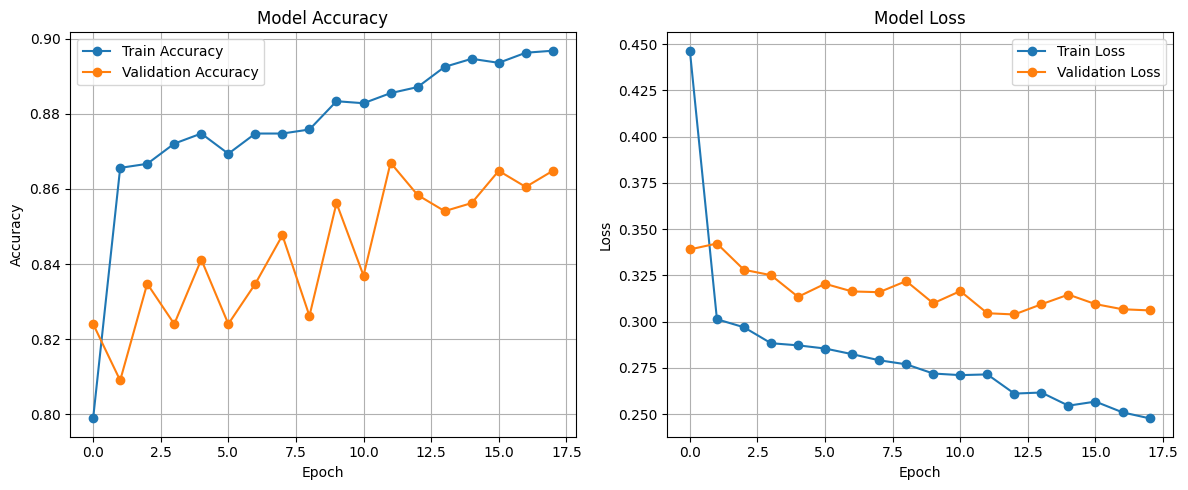

In [18]:
# visualisasi
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [19]:
loss, acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {acc:.2f}")

# Predict 14 days ahead
last_14_days = scaled_features[-WINDOW_SIZE:]  # ambil 14 hari terakhir
predictions = []

window = last_14_days.copy()
for _ in range(14):  # prediksi 14 hari ke depan
    input_window = np.expand_dims(window, axis=0)
    prob = model.predict(input_window)[0][0]
    prediction = 1 if prob > 0.5 else 0
    predictions.append(prediction)

    # Buat dummy next day (tanpa fitur masa depan), kita hanya duplikasikan nilai terakhir
    next_day = window[-1].copy()
    window = np.vstack([window[1:], next_day])

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7726 - loss: 0.4877

Test Accuracy: 0.82
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step



Prediksi apakah akan hujan dalam 14 hari ke depan (1=Ya, 0=Tidak):
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


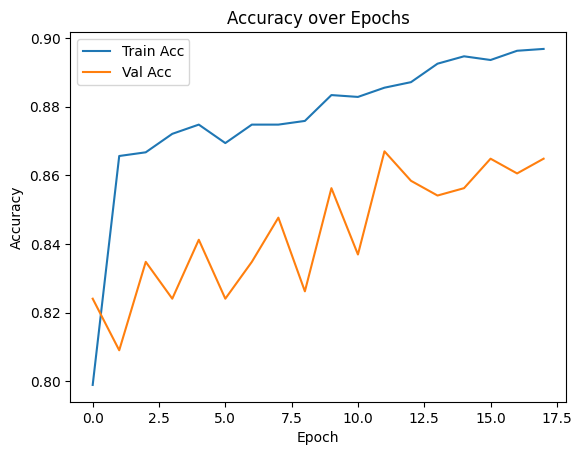

In [20]:
print("\nPrediksi apakah akan hujan dalam 14 hari ke depan (1=Ya, 0=Tidak):")
print(predictions)

# Opsional: Plot akurasi
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


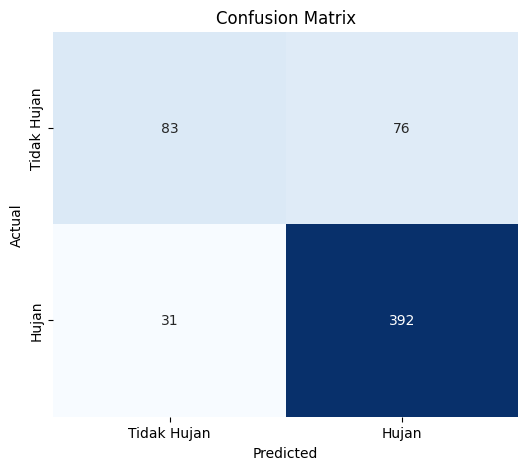

In [21]:
# prediksi data uji
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# confusion matriks
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Tidak Hujan', 'Hujan'],
            yticklabels=['Tidak Hujan', 'Hujan'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [22]:
# report akurasi

print(classification_report(y_test, y_pred, target_names=["Tidak Hujan", "Hujan"]))


              precision    recall  f1-score   support

 Tidak Hujan       0.73      0.52      0.61       159
       Hujan       0.84      0.93      0.88       423

    accuracy                           0.82       582
   macro avg       0.78      0.72      0.74       582
weighted avg       0.81      0.82      0.81       582



# **Kesimpulan**

Model LSTM berhasil dibangun dan digunakan untuk memprediksi curah hujan selama 7 hari ke depan berdasarkan data historis cuaca Jakarta tahun 2013–2020.

Beberapa poin penting dari proyek ini:
- Model mampu mencapai akurasi sekitar 87% pada data uji.
- Grafik akurasi dan loss menunjukkan bahwa model belajar dengan baik dan tidak mengalami overfitting.
- Prediksi yang dihasilkan menunjukkan kemampuan model dalam menangkap pola temporal dari data cuaca.

Model ini dapat digunakan sebagai dasar sistem prediksi cuaca sederhana dan bisa dikembangkan lebih lanjut dengan data tambahan atau tuning hyperparameter lebih lanjut.
